# CutMix, MixUp, and RandAugment image augmentation with KerasCV

## Imports & setup


In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/MyDrive/[2024-2025]AN2DL/Homework1



Mounted at /gdrive
/gdrive/MyDrive/[2024-2025]AN2DL/Homework1


In [ ]:
%%capture
!pip install keras_cv
import keras_cv

We begin by importing all required packages:

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import matplotlib.pyplot as plt


# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
import keras as tfk
from keras.layers import Input, Dense, Dropout, Lambda, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from keras import layers as tfkl
import keras_cv

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Tensorflow version -> 2.17.0
Keras version -> 3.4.1


## Data loading


In [ ]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()

import numpy as np


data = np.load(
        'cleaned_data_dedup.npz'
)
X = data['images']
y = data['labels']


# data, dataset_info = tfds.load("oxford_flowers102", with_info=True, as_supervised=True)
# train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
# val_steps_per_epoch = dataset_info.splits["test"].num_examples // BATCH_SIZE

In [ ]:
class_mapping = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet"
}

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

class_names =  list(class_mapping.values())

#y_train = tfk.utils.to_categorical(y_train, num_classes=len(class_names))
#y_val = tfk.utils.to_categorical(y_val, num_classes=len(class_names))

data_train = tf.data.Dataset.from_tensor_slices((X_train, y_train.flatten())).batch(BATCH_SIZE, drop_remainder=True)
data_val = tf.data.Dataset.from_tensor_slices((X_val, y_val.flatten())).batch(BATCH_SIZE, drop_remainder=True)
data_test = tf.data.Dataset.from_tensor_slices((X_test, y_test.flatten())).batch(BATCH_SIZE, drop_remainder=True)

print(data_val)
#train_steps_per_epoch = X.shape[0] // BATCH_SIZE
#val_steps_per_epoch = X.shape[0] // BATCH_SIZE

In [ ]:
IMAGE_SIZE = (96, 96)
num_classes = 8


def to_dict(image, label):
    #image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, num_classes)

    return {"images": image, "labels": label}


def prepare_dataset(dataset, split):
    if split == "train":
        return (
            dataset.shuffle(10 * BATCH_SIZE)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
        )
    else:
        return dataset.map(to_dict, num_parallel_calls=AUTOTUNE)


def load_dataset(split="train"):
    if split == "train":
      dataset = data_train
    elif split == "val":
      dataset = data_val

    else:
      dataset = data_test
    return prepare_dataset(dataset, split)


train_dataset = load_dataset()

Let's inspect some samples from our dataset:

In [ ]:

def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        print(images.shape)
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()


visualize_dataset(train_dataset, title="Before Augmentation")

Great! Now we can move onto the augmentation step.

## RandAugment

[RandAugment](https://arxiv.org/abs/1909.13719)


In [ ]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=1.0,
)


def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs


train_dataset = load_dataset().map(apply_rand_augment, num_parallel_calls=AUTOTUNE)

Finally, let's inspect some of the results:

(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)


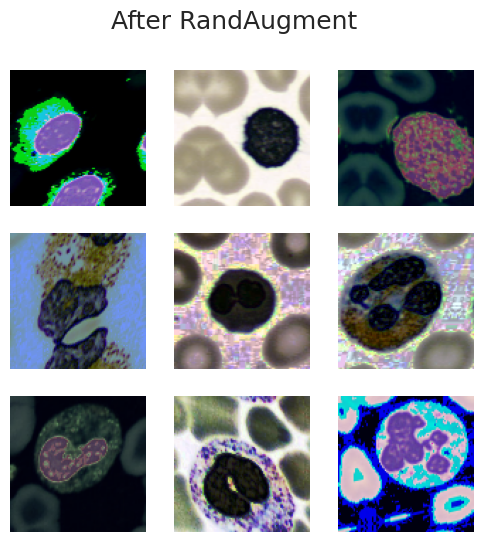

In [ ]:
visualize_dataset(train_dataset, title="After RandAugment")

Try tweaking the magnitude settings to see a wider variety of results.

## CutMix and MixUp: generate high-quality inter-class examples

- [CutMix: Train Strong Classifiers](https://arxiv.org/abs/1905.04899)
- [MixUp: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)


(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)


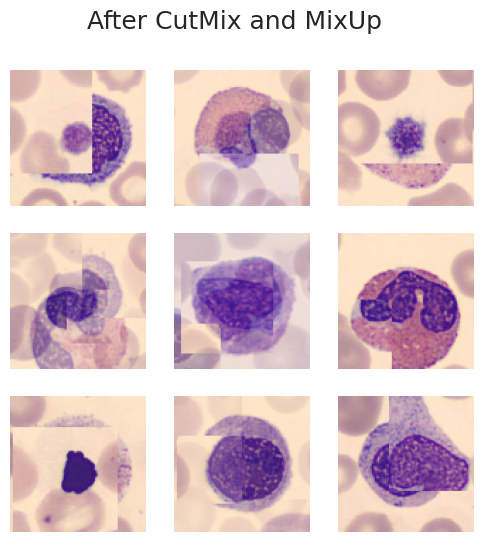

In [ ]:
cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()


def cut_mix_and_mix_up(samples):
    samples = cut_mix(samples, training=True)
    samples = mix_up(samples, training=True)
    return samples


train_dataset = load_dataset().map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)

visualize_dataset(train_dataset, title="After CutMix and MixUp")

Great! Looks like we have successfully added `CutMix` and `MixUp` to our preprocessing
pipeline.

## Training a CNN

(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)


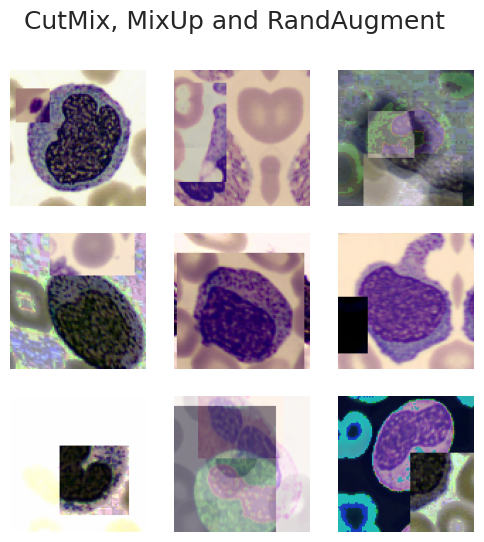

In [ ]:

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels


train_dataset = (
    load_dataset()
    .map(apply_rand_augment, num_parallel_calls=AUTOTUNE)
    .map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
)

visualize_dataset(train_dataset, "CutMix, MixUp and RandAugment")

train_dataset = train_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

val_dataset = load_dataset(split="val")
val_dataset = val_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

test_dataset = load_dataset(split="test")
test_dataset = test_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.prefetch(AUTOTUNE)
test_dataset = test_dataset.prefetch(AUTOTUNE)


In [ ]:
input_shape = (96, 96, 3)
print(input_shape)

import tensorflow.keras as tfk
import keras.layers as tfkl
from keras.layers import Dense

EfficientNet = tfk.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
)

output_shape = 8

def efficientNet_tl(input_shape=input_shape, output_shape=output_shape, name="EfficientNet"):

  # augmentation = tfk.Sequential([
  #     #keras_cv.layers.RandomSharpness(0.3, [0, 255]),
  #     #keras_cv.layers.RandomShear(0.3, 0.3),
  #     #keras_cv.layers.RandomCutout(0.4, 0.4),
  #     #keras_cv.layers.AutoContrast([0, 255]),
  #     tfk.layers.RandomTranslation(0.1, 0.1, fill_mode="constant"),
  #     tfk.layers.RandomFlip("horizontal_and_vertical"),
  #     tfk.layers.RandomRotation(0.25, fill_mode="constant"),
  #     tfk.layers.RandomZoom(0.2, fill_mode="constant"),
  #     #tfk.layers.RandomBrightness(0.1),
  #     #tfk.layers.RandomContrast(0.1),
  # ], name='preprocessing')


  inputs = tfkl.Input(shape=input_shape, name='input_layer')

  x = inputs
  #x = augmentation(inputs)


  x = EfficientNet(x)

  x = tfk.layers.GlobalAveragePooling2D()(x)

  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  x = Dense(128, activation='relu')(x)  # Optional dense layer for additional learning capacity

  x = tfk.layers.BatchNormalization()(x)
  x = tfk.layers.Dropout(0.2)(x)

  predictions = Dense(8, activation='softmax')(x)  # Adjusted to 8 classes

  # Create a new model with these layers
  model = tfk.Model(inputs=inputs, outputs=predictions, name=name)

  # Optionally, freeze layers of the base model if needed
  for layer in EfficientNet.layers:
      layer.trainable = False

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

(96, 96, 3)
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [ ]:
for batch in train_dataset.take(1):
    print(batch[0].shape)
    print(batch[1].shape)
    break

(32, 96, 96, 3)
(32, 8)


Finally we train the model:

In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
    # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-5)
]

model = efficientNet_tl()
history = model.fit(
    train_dataset,
    epochs=300,
    validation_data=val_dataset,
    callbacks=callbacks,

).history

final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

file_name = model.name + "_" + str(final_val_accuracy) + '.keras'

model.save(file_name)


Epoch 1/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 95s 101ms/step - accuracy: 0.2548 - loss: 2.2520 - val_accuracy: 0.5616 - val_loss: 1.4251
Epoch 2/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.3541 - loss: 1.9017 - val_accuracy: 0.7049 - val_loss: 1.0356
Epoch 3/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3800 - loss: 1.8322 - val_accuracy: 0.7214 - val_loss: 0.9484
Epoch 4/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3993 - loss: 1.7998 - val_accuracy: 0.7500 - val_loss: 0.8943
Epoch 5/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.4087 - loss: 1.7673 - val_accuracy: 0.7691 - val_loss: 0.8610
Epoch 6/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4012 - loss: 1.7569 - val_accuracy: 0.7856 - val_loss: 0.8061
Epoch 7/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.3935 - loss: 1.7599 - val_accuracy: 0.7240 - val_loss: 0.8610
Epoch 8/300
290/290 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4153 - loss: 

In [ ]:
# test it
preds = model.evaluate(test_dataset)
print(preds)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8500 - loss: 0.6217
[0.6320270299911499, 0.8498263955116272]


In [ ]:
%ls

 basic_conv_gap2_89.91.keras             __pycache__/
 cleaned_data_dedup_balanced.npz         requirements.txt
 cleaned_data_dedup.npz                  ResNet50_no_aug_75.25.keras
 cleaned_data.npz                        ResNet50_no_aug_76.58.keras
 CreateTestingSet.ipynb                  ResNet50_no_aug_76.78.keras
 cut_mix_mix_up_and_rand_augment.ipynb   ResNet50_no_aug_77.4.keras
 Data_cleaning.ipynb                     ResNet50_no_aug_95.3.keras
 deduplicated_training_set.npz           std_image.npy
 EfficientNet_84.2.keras                 submission_241116_145745.zip
 EfficientNet_96.19.keras                submission_241116_172429.zip
 EfficientNet_99.15.keras                submission_241116_173753.zip
'Homework 1 - Melvin.ipynb'              submission_241116_173834.zip
 Homework_1_MobileNetV2.ipynb            submission_241117_161835.zip
 mean_image.npy                          submission_241117_171531.zip
 model.py                                submission_241117_183354.zip


In [ ]:
def fine_tune_effNet():
    ft_model = tfk.models.load_model('EfficientNet_84.2.keras')

    ft_model.get_layer('efficientnetb7').trainable = True

    # Set all MobileNetV3Small layers as non-trainable
    for layer in ft_model.get_layer('efficientnetb7').layers:
        layer.trainable = False

    # Enable training only for Conv2D and DepthwiseConv2D layers
    for i, layer in enumerate(ft_model.get_layer('efficientnetb7').layers):
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
            layer.trainable = True
            print(i, layer.name, type(layer).__name__, layer.trainable)

    N_freeze = 500

    for layer in ft_model.get_layer('efficientnetb7').layers[:N_freeze]:
        layer.trainable = False
        print(layer.name, layer.trainable)

    ft_model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.RMSprop(learning_rate = 1e-4),
        metrics=['accuracy']
    )

    return ft_model


In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
    # tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-5)
]

model = fine_tune_effNet()
history = model.fit(
    train_dataset,
    epochs=300,
    validation_data=val_dataset,
    callbacks=callbacks,

).history

final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

file_name = "Fine_tune" +  model.name + "_" + str(final_val_accuracy) + '.keras'

model.save(file_name)

5 stem_conv Conv2D True
8 block1a_dwconv DepthwiseConv2D True
13 block1a_se_reduce Conv2D True
14 block1a_se_expand Conv2D True
16 block1a_project_conv Conv2D True
18 block1b_dwconv DepthwiseConv2D True
23 block1b_se_reduce Conv2D True
24 block1b_se_expand Conv2D True
26 block1b_project_conv Conv2D True
30 block1c_dwconv DepthwiseConv2D True
35 block1c_se_reduce Conv2D True
36 block1c_se_expand Conv2D True
38 block1c_project_conv Conv2D True
42 block1d_dwconv DepthwiseConv2D True
47 block1d_se_reduce Conv2D True
48 block1d_se_expand Conv2D True
50 block1d_project_conv Conv2D True
54 block2a_expand_conv Conv2D True
58 block2a_dwconv DepthwiseConv2D True
63 block2a_se_reduce Conv2D True
64 block2a_se_expand Conv2D True
66 block2a_project_conv Conv2D True
68 block2b_expand_conv Conv2D True
71 block2b_dwconv DepthwiseConv2D True
76 block2b_se_reduce Conv2D True
77 block2b_se_expand Conv2D True
79 block2b_project_conv Conv2D True
83 block2c_expand_conv Conv2D True
86 block2c_dwconv Depthwis

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

NameError: name 'plt' is not defined

In [ ]:
def fine_fine_tune_effNet():
    ft_model = tfk.models.load_model('Fine_tuneEfficientNet_98.7.keras')

    ft_model.get_layer('efficientnetb7').trainable = True

    # Set all MobileNetV3Small layers as non-trainable
    for layer in ft_model.get_layer('efficientnetb7').layers:
        layer.trainable = False

    # Enable training only for Conv2D and DepthwiseConv2D layers
    for i, layer in enumerate(ft_model.get_layer('efficientnetb7').layers):
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
            layer.trainable = True
            print(i, layer.name, type(layer).__name__, layer.trainable)

    N_freeze = 430

    for layer in ft_model.get_layer('efficientnetb7').layers[:N_freeze]:
        layer.trainable = False
        print(layer.name, layer.trainable)

    ft_model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.RMSprop(learning_rate = 1e-5),
        metrics=['accuracy']
    )

    return ft_model


In [ ]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=4, factor=0.5, min_lr=1e-6)
]

model = fine_fine_tune_effNet()
history = model.fit(
    train_dataset,
    epochs=130,
    validation_data=val_dataset,
    callbacks=callbacks,

).history

final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

file_name = "Fine_Fine_tune" +  model.name + "_" + str(final_val_accuracy) + '.keras'

model.save(file_name)

5 stem_conv Conv2D True
8 block1a_dwconv DepthwiseConv2D True
13 block1a_se_reduce Conv2D True
14 block1a_se_expand Conv2D True
16 block1a_project_conv Conv2D True
18 block1b_dwconv DepthwiseConv2D True
23 block1b_se_reduce Conv2D True
24 block1b_se_expand Conv2D True
26 block1b_project_conv Conv2D True
30 block1c_dwconv DepthwiseConv2D True
35 block1c_se_reduce Conv2D True
36 block1c_se_expand Conv2D True
38 block1c_project_conv Conv2D True
42 block1d_dwconv DepthwiseConv2D True
47 block1d_se_reduce Conv2D True
48 block1d_se_expand Conv2D True
50 block1d_project_conv Conv2D True
54 block2a_expand_conv Conv2D True
58 block2a_dwconv DepthwiseConv2D True
63 block2a_se_reduce Conv2D True
64 block2a_se_expand Conv2D True
66 block2a_project_conv Conv2D True
68 block2b_expand_conv Conv2D True
71 block2b_dwconv DepthwiseConv2D True
76 block2b_se_reduce Conv2D True
77 block2b_se_expand Conv2D True
79 block2b_project_conv Conv2D True
83 block2c_expand_conv Conv2D True
86 block2c_dwconv Depthwis

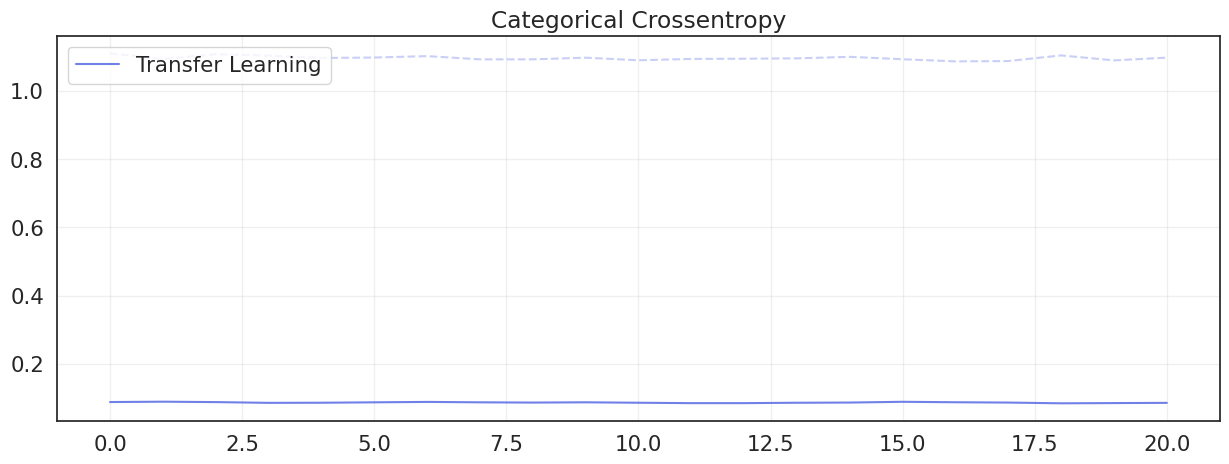

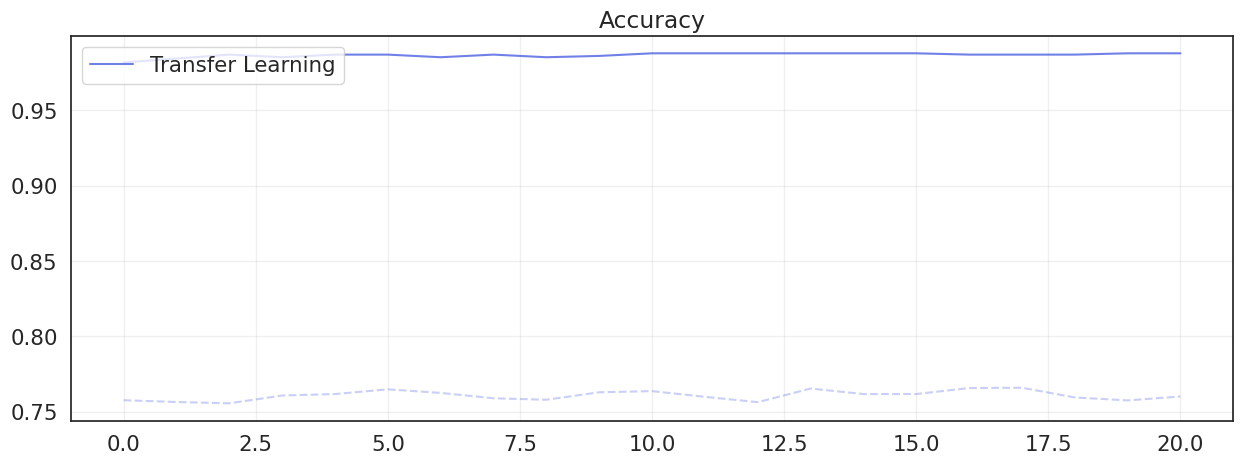

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()